In [1]:
import geopandas as gpd
import xarray as xr
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import gzip
import shutil
import glob
import datetime as dt

In [2]:
%env OPENBLAS_NUM_THREADS=4

env: OPENBLAS_NUM_THREADS=4


In [3]:
# Set data directory
data_dir = '../../datasets/'

monthly_sh = os.path.join(data_dir, 'ITSG_grace_data/monthly/monthly_n96/')
static =  os.path.join(data_dir, 'ITSG_grace_data/monthly/static/')
background =  os.path.join(data_dir, 'ITSG_grace_data/monthly/monthly_background/')
# grace_fo = os.path.join(data_dir, 'grace_fo/')

In [4]:
aoi = os.path.join(data_dir, 'gha/gha.shp')
gha = gpd.read_file(aoi)

gha.head(5)

,OBJECTID,COUNTRY,area,Shape_Leng,Shape_Area,land_under,geometry
0,1,Burundi,0.0,8.560371,2.193095,None,"POLYGON ((30.36003 -2.35343, 30.36209 -2.35250..."
1,2,Djibouti,0.0,7.874779,1.781569,None,"POLYGON ((42.66339 11.07150, 42.65628 11.07671..."
2,3,Eritrea,0.0,41.125347,10.077064,None,"MULTIPOLYGON (((43.14681 12.71384, 43.14167 12..."
3,4,Ethiopia,0.0,49.028874,92.986294,None,"POLYGON ((41.77824 11.54207, 41.77785 11.51077..."
4,5,Kenya,0.0,40.625985,47.319578,None,"MULTIPOLYGON (((39.40283 -4.65471, 39.40523 -4..."


### Read monthly solutions Stokes coefficients form directory path

In [5]:
def load_icgem_files(datadir):

    gsm = []
    gsmf = [] # GFO
    deg1_terms = []
    term_c20 = []
    gaa =[]
    files = os.listdir(datadir)

    for file in files:
        file_path = os.path.join(datadir, file)
        if "ITSG-Grace" in file:
            gsm.append(xr.open_dataset(file_path, engine="icgem"))
        elif "c20" in file:
            term_c20.append(xr.open_dataset(file_path, engine="icgem"))
        elif "GSM-2" in file:
             gsmf.append(xr.open_dataset(file_path, engine="gsmv6")) #GRACE-FO
        # elif "GAA" in file:
        #      gaa.append(xr.open_dataset(file_path, engine="gsmv6")) #GRACE-FO        
        elif "degree1" in file:
            deg1_terms.append(xr.open_dataset(file_path, engine="icgem"))  ## Depending on the gravitational spherical harmonic model, the engine can be = "gsmv6"

    if deg1_terms and term_c20:
        deg1_cnm = xr.concat(deg1_terms, dim="time").sortby("time")
        c20_cnm = xr.concat(term_c20, dim="time").sortby("time")
        return deg1_cnm, c20_cnm
    elif gsmf and gaa:
        dsgsmf = xr.concat(gsmf, dim="time").sortby("time")
        dsgaa = xr.concat(gaa, dim="time").sortby("time")
        return dsgsmf, dsgaa
    else:
        dsgsm = xr.concat(gsm, dim="time")
        dsgsm = dsgsm.sortby('time')
        return dsgsm

In [6]:
# Load monthly data

monthly_data = os.path.expanduser(monthly_sh)

monthly_sh_data = load_icgem_files(monthly_data)
monthly_sh_data

<xarray.Dataset>
Dimensions:  (time: 237, nm: 9409)
Coordinates:
  * nm       (nm) object MultiIndex
  * n        (nm) int64 0 1 1 1 2 2 2 2 2 3 3 ... 96 96 96 96 96 96 96 96 96 96
  * m        (nm) int64 0 0 1 -1 0 1 -1 2 -2 ... -92 93 -93 94 -94 95 -95 96 -96
  * time     (time) datetime64[ns] 2002-04-15T12:00:00 ... 2024-10-15T12:00:00
Data variables:
    cnm      (time, nm) float64 1.0 0.0 0.0 ... 3.144e-10 -2.291e-09 1.345e-09
    sigcnm   (time, nm) float64 0.0 0.0 0.0 ... 6.981e-11 5.304e-11 5.283e-11
Attributes:
    nmaxfile:   96
    nmax:       96
    format:     icgem
    norm:       fully_normalized
    gm:         398600441500000.0
    re:         6378136.3
    modelname:  ITSG-Grace2018_n96_2013-12

### Degree corrections

#### C20 coefficient correction 

In [7]:
# File path (replace with your file's path)
file_path = os.path.join(background, "cd20_RL06.txt")

# Read the file while skipping the header lines
data = pd.read_csv(
    file_path,
    delim_whitespace=True,  # Use whitespace as delimiter
    comment='#',            # Skip lines starting with '#'
    header=None,            # No predefined header
    names=[
        "Mid_Point", "C20", "Delta_C20", "Sigma", "Mean_AOD", 
        "Start_Date", "End_Date"
    ]  # Column names
)

# Convert 'Start_Date' and 'End_Date' to datetime
data['Start_Date'] = data['Start_Date'].apply(lambda x: dt.datetime.strptime(str(int(x)), "%Y%m%d"))
data['End_Date'] = data['End_Date'].apply(lambda x: dt.datetime.strptime(str(int(x)), "%Y%m%d"))

data.head()

,Mid_Point,C20,Delta_C20,Sigma,Mean_AOD,Start_Date,End_Date
0,2002.0411,-0.000484,0.9592,0.3274,0.4373,2002-01-01,2002-02-01
1,2002.1259,-0.000484,0.0182,0.2493,-0.4052,2002-02-01,2002-03-01
2,2002.2026,-0.000484,0.8918,0.2390,0.4156,2002-03-01,2002-04-01
3,2002.2875,-0.000484,1.3861,0.3813,0.2722,2002-04-01,2002-05-01
4,2002.3696,-0.000484,1.9160,0.3578,0.7870,2002-05-01,2002-06-01


In [8]:
# Create an xarray Dataset with only 'C20' and 'date'
gds = xr.Dataset(
    data_vars={
        'm': (['time'], data['C20'].values),
    },
    coords={
        'time': data['Start_Date'].values,
    }
)

gds

<xarray.Dataset>
Dimensions:  (time: 275)
Coordinates:
  * time     (time) datetime64[ns] 2002-01-01 2002-02-01 ... 2024-11-01
Data variables:
    m        (time) float64 -0.0004842 -0.0004842 ... -0.0004842 -0.0004842

In [9]:
# Read the degree  coefficients
background_data = os.path.expanduser(background)

ds_deg1, ds_c20 = load_icgem_files(background_data)

In [10]:
ds_deg1

<xarray.Dataset>
Dimensions:  (time: 162, nm: 4)
Coordinates:
  * nm       (nm) object MultiIndex
  * n        (nm) int64 0 1 1 1
  * m        (nm) int64 0 0 1 -1
  * time     (time) datetime64[ns] 2002-04-15T12:00:00 ... 2017-06-15T12:00:00
Data variables:
    cnm      (time, nm) float64 0.0 6.217e-10 ... -6.684e-11 -8.638e-11
Attributes:
    nmaxfile:   1
    nmax:       1
    format:     icgem
    norm:       fully_normalized
    gm:         398600441500000.0
    re:         6378136.3
    modelname:  model_degree1_2002-11

In [11]:
c20_aligned = gds['m'].sel(time=monthly_sh_data['time'], method='nearest')

In [12]:
c20_aligned

<xarray.DataArray 'm' (time: 237)>
array([-0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
...
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417, -0.00048417, -0.00048417, -0.00048417,
       -0.00048417, -0.00048417])
Coordinates:
  * time     (time) datetime64[ns] 2002-04-01 2002-05-01 ... 2024-10-01

In [13]:
# Select degree 20 order 0
c20 = ds_c20.cnm.sel(n=2, m =0)

monthly_sh_data.cnm.loc[{'n': 2, 'm': 0}]= c20_aligned.values

In [14]:
monthly_sh_data

<xarray.Dataset>
Dimensions:  (time: 237, nm: 9409)
Coordinates:
  * nm       (nm) object MultiIndex
  * n        (nm) int64 0 1 1 1 2 2 2 2 2 3 3 ... 96 96 96 96 96 96 96 96 96 96
  * m        (nm) int64 0 0 1 -1 0 1 -1 2 -2 ... -92 93 -93 94 -94 95 -95 96 -96
  * time     (time) datetime64[ns] 2002-04-15T12:00:00 ... 2024-10-15T12:00:00
Data variables:
    cnm      (time, nm) float64 1.0 0.0 0.0 ... 3.144e-10 -2.291e-09 1.345e-09
    sigcnm   (time, nm) float64 0.0 0.0 0.0 ... 6.981e-11 5.304e-11 5.283e-11
Attributes:
    nmaxfile:   96
    nmax:       96
    format:     icgem
    norm:       fully_normalized
    gm:         398600441500000.0
    re:         6378136.3
    modelname:  ITSG-Grace2018_n96_2013-12

In [15]:
# Select degree 1 terms
deg1_terms = ds_deg1.cnm.sel(n=1)

In [24]:
display(ds_deg1)
deg1_terms = ds_deg1.sh.truncate(1,1) ## only select degree 1 terms
display(deg1_terms)

<xarray.Dataset>
Dimensions:  (time: 162, nm: 4)
Coordinates:
  * nm       (nm) object MultiIndex
  * n        (nm) int64 0 1 1 1
  * m        (nm) int64 0 0 1 -1
  * time     (time) datetime64[ns] 2002-04-15T12:00:00 ... 2017-06-15T12:00:00
Data variables:
    cnm      (time, nm) float64 0.0 6.217e-10 ... -6.684e-11 -8.638e-11
Attributes:
    nmaxfile:   1
    nmax:       1
    format:     icgem
    norm:       fully_normalized
    gm:         398600441500000.0
    re:         6378136.3
    modelname:  model_degree1_2002-11

<xarray.Dataset>
Dimensions:  (time: 162, nm: 3)
Coordinates:
  * nm       (nm) object MultiIndex
  * n        (nm) int64 1 1 1
  * m        (nm) int64 0 1 -1
  * time     (time) datetime64[ns] 2002-04-15T12:00:00 ... 2017-06-15T12:00:00
Data variables:
    cnm      (time, nm) float64 6.217e-10 1.842e-10 ... -6.684e-11 -8.638e-11
Attributes:
    nmaxfile:   1
    nmax:       1
    format:     icgem
    norm:       fully_normalized
    gm:         398600441500000.0
    re:         6378136.3
    modelname:  model_degree1_2002-11

In [1]:
# # Update the terms
# for m in [0, 1, -1]:
#     monthly_sh_data.cnm.loc[{'n': 1, 'm': m}] = deg1_terms.sel(m=m)

In [18]:
monthly_sh_data

<xarray.Dataset>
Dimensions:  (time: 237, nm: 9409)
Coordinates:
  * nm       (nm) object MultiIndex
  * n        (nm) int64 0 1 1 1 2 2 2 2 2 3 3 ... 96 96 96 96 96 96 96 96 96 96
  * m        (nm) int64 0 0 1 -1 0 1 -1 2 -2 ... -92 93 -93 94 -94 95 -95 96 -96
  * time     (time) datetime64[ns] 2002-04-15T12:00:00 ... 2024-10-15T12:00:00
Data variables:
    cnm      (time, nm) float64 1.0 0.0 0.0 ... 3.144e-10 -2.291e-09 1.345e-09
    sigcnm   (time, nm) float64 0.0 0.0 0.0 ... 6.981e-11 5.304e-11 5.283e-11
Attributes:
    nmaxfile:   96
    nmax:       96
    format:     icgem
    norm:       fully_normalized
    gm:         398600441500000.0
    re:         6378136.3
    modelname:  ITSG-Grace2018_n96_2013-12

#### Read the time-invariable static gravity field data

In [19]:

static_data = os.path.expanduser(static)
name= "ITSG-Grace2018s.gfc"
file_path = os.path.join(static_data, name)
dsstatic = xr.open_dataset(file_path, engine="icgem")
dsstatic

<xarray.Dataset>
Dimensions:  (nm: 40401)
Coordinates:
  * nm       (nm) object MultiIndex
  * n        (nm) int64 0 1 1 1 2 2 2 2 2 ... 200 200 200 200 200 200 200 200
  * m        (nm) int64 0 0 1 -1 0 1 -1 2 ... -197 198 -198 199 -199 200 -200
Data variables:
    cnm      (nm) float64 ...
    sigcnm   (nm) float64 ...
Attributes:
    nmaxfile:   200
    nmax:       200
    format:     icgem
    norm:       fully_normalized
    gm:         398600441500000.0
    re:         6378136.3
    modelname:  ITSG-Grace2018s

In [20]:
# Substract static field from sh data
monthly_sh_data["dcnm"]=monthly_sh_data.cnm-dsstatic.cnm

In [21]:
# 
ds1 = monthly_sh_data.sh.truncate(monthly_sh_data.sh.nmax, 1)

In [25]:
ds1

<xarray.Dataset>
Dimensions:  (time: 237, nm: 9408)
Coordinates:
  * nm       (nm) object MultiIndex
  * n        (nm) int64 1 1 1 2 2 2 2 2 3 3 3 ... 96 96 96 96 96 96 96 96 96 96
  * m        (nm) int64 0 1 -1 0 1 -1 2 -2 0 ... -92 93 -93 94 -94 95 -95 96 -96
  * time     (time) datetime64[ns] 2002-04-15T12:00:00 ... 2024-10-15T12:00:00
Data variables:
    cnm      (time, nm) float64 0.0 0.0 0.0 ... 3.144e-10 -2.291e-09 1.345e-09
    sigcnm   (time, nm) float64 0.0 0.0 0.0 ... 6.981e-11 5.304e-11 5.283e-11
    dcnm     (time, nm) float64 0.0 0.0 0.0 ... 3.959e-11 -5.717e-11 -1.873e-10
Attributes:
    nmaxfile:   96
    nmax:       96
    format:     icgem
    norm:       fully_normalized
    gm:         398600441500000.0
    re:         6378136.3
    modelname:  ITSG-Grace2018_n96_2013-12

#### Calculate terrestrial water storage change in spectral domain

In [26]:
datws=ds1.dcnm.sh.tws()
display(datws)

shxarray-INFO: /home/jovyan/.cache/shxarray_storage/Love/geoslurp_dump_llove.sql already exists, no need to download)


<xarray.DataArray 'tws' (time: 237, nm: 9408)>
array([[ 0.        ,  0.        ,  0.        , ..., -0.38059965,
        -0.11055052,  0.13402338],
       [ 0.        ,  0.        ,  0.        , ...,  0.08039811,
        -0.00237433, -0.49129344],
       [ 0.        ,  0.        ,  0.        , ...,  0.07287001,
        -0.04689879, -0.0708848 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.0681484 ,
         0.14268507, -0.04169044],
       [ 0.        ,  0.        ,  0.        , ...,  0.24516564,
        -0.16843007,  0.0936703 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.09100389,
        -0.1314255 , -0.43065308]])
Coordinates:
  * nm       (nm) object MultiIndex
  * n        (nm) int64 1 1 1 2 2 2 2 2 3 3 3 ... 96 96 96 96 96 96 96 96 96 96
  * m        (nm) int64 0 1 -1 0 1 -1 2 -2 0 ... -92 93 -93 94 -94 95 -95 96 -96
  * time     (time) datetime64[ns] 2002-04-15T12:00:00 ... 2024-10-15T12:00:00
Attributes:
    units:      m
    long_name:  Total water storage
    gravtype:   tws

#### Calculate terrestrial water storage change in spatial domain globally

In [27]:
dsgrd=datws.sh.synthesis()

In [28]:
dsgrd = dsgrd.to_dataset(name='tws')

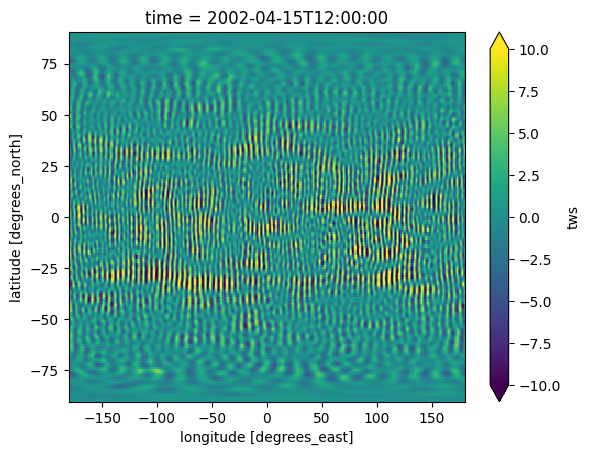

In [29]:
islice=0
dsgrd.tws[:,:,islice].plot(vmin=-10, vmax =10)
dsgrd
lats = dsgrd['lat'].values
lons = dsgrd['lon'].values

#### Apply filters

In [30]:
# Guassian isotropic filter
dsgrd["twsgauss"]=datws.sh.filter('Gauss350').sh.synthesis()
# Anisotropic decorrelation filter
dsgrd["twsddk"]=datws.sh.filter('DDK3').sh.synthesis()


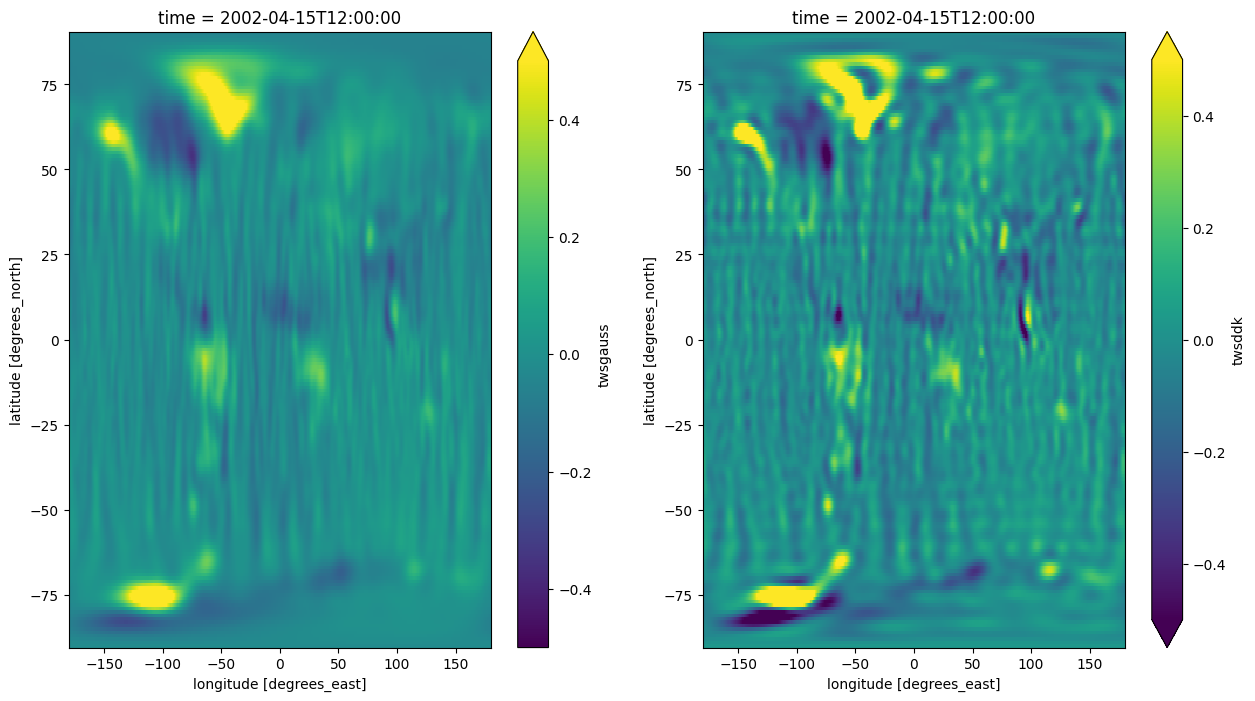

In [36]:
fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(15, 8))
vmin=-0.5
vmax=0.5

islice=0
dsgrd.twsgauss[:,:,islice].plot(ax=axs[0],vmin=vmin,vmax=vmax)
dsgrd.twsddk[:,:,islice].plot(ax=axs[1],vmin=vmin,vmax=vmax)

Text(0.5, 1.0, 'DDK3 Filter')

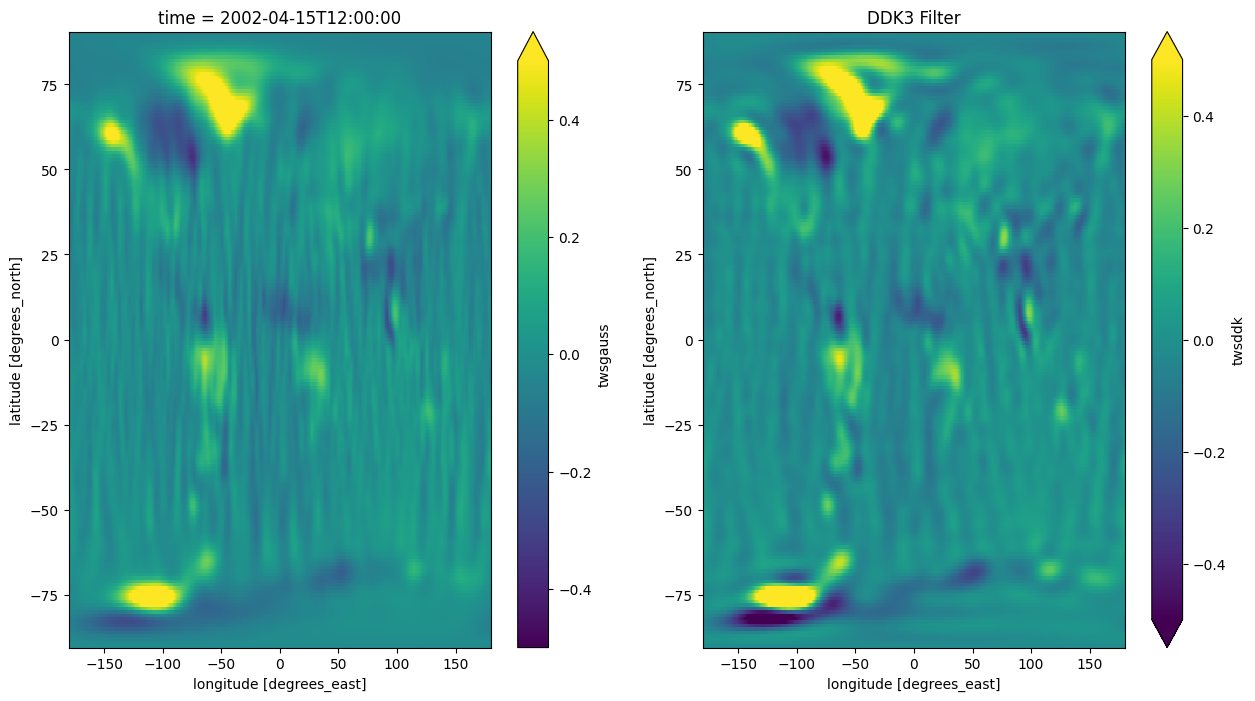

In [31]:
fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(15, 8))
vmin=-0.5
vmax=0.5

islice=0
dsgrd.twsgauss[:,:,islice].plot(ax=axs[0],vmin=vmin,vmax=vmax)
dsgrd.twsddk[:,:,islice].plot(ax=axs[1],vmin=vmin,vmax=vmax)
plt.title('DDK3 Filter')

In [37]:
dsgrd

<xarray.Dataset>
Dimensions:   (time: 237, lat: 181, lon: 361)
Coordinates:
  * time      (time) datetime64[ns] 2002-04-15T12:00:00 ... 2024-10-15T12:00:00
  * lat       (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon       (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
Data variables:
    tws       (lat, lon, time) float64 0.4011 -0.1676 ... -0.02375 -0.02179
    twsgauss  (lat, lon, time) float64 -0.02231 -0.007879 ... -0.01586 0.02431
    twsddk    (lat, lon, time) float64 0.0283 -0.01512 ... -0.02111 0.0303

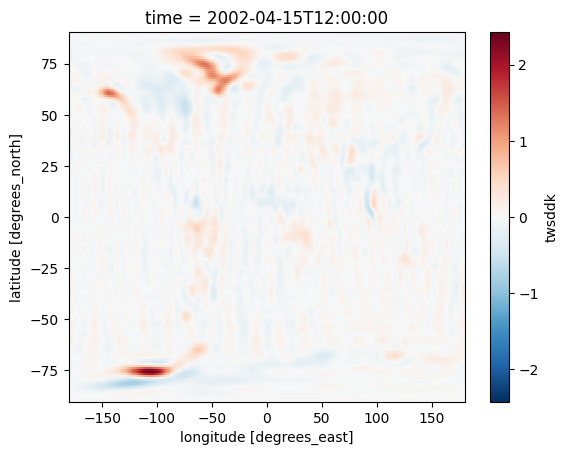

In [38]:
dsgrd.twsddk.isel(time=0).plot()

### Export the TWS for GHA

 #### Save to file

In [40]:
# Set spatial dimensions and CRS
data = dsgrd.twsddk.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
data = data.rio.write_crs("epsg:4326", inplace=True)

# Load the shapefile using geopandas
gdf = gha.to_crs(data.rio.crs)

# Extract geometries from the GeoDataFrame
geometries = gdf.geometry

# Clip the dataset using the geometries
gha_tws = data.rio.clip(geometries, gdf.crs)

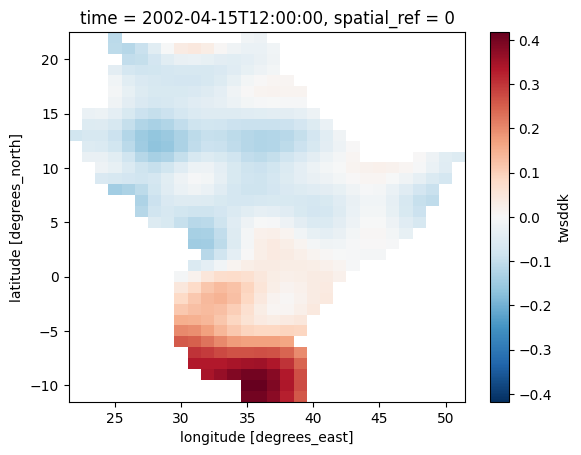

In [42]:
gha_tws.isel(time=0).plot()

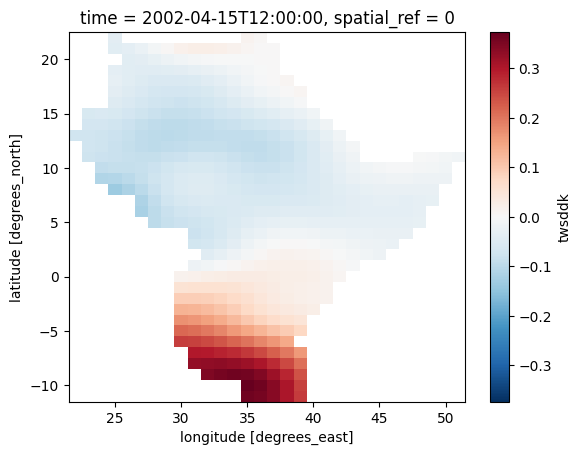

In [32]:
# Set spatial dimensions and CRS
data = dsgrd.twsddk.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
data = data.rio.write_crs("epsg:4326", inplace=True)

# Load the shapefile using geopandas
gdf = gha.to_crs(data.rio.crs)

# Extract geometries from the GeoDataFrame
geometries = gdf.geometry

# Clip the dataset using the geometries
gha_tws = data.rio.clip(geometries, gdf.crs)
gha_tws.isel(time=0).plot()

In [45]:
# Save the output TWS
gha_tws.to_netcdf(os.path.join(data_dir, "gha_tws.nc"))

In [51]:
gha_tws.isel(time=0).rio.to_raster("planet_scope.tif")

## TWS pre-processing

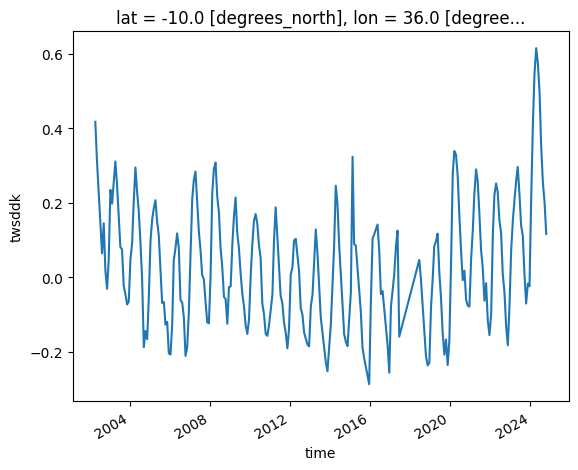

In [63]:
gha_tws.sel(lon=36, lat=-10,).plot()
